## TabTransformer

## Test Accuracy

In [2]:
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import arff


### Jannis


In [4]:
# Replace 'your_file.arff' with the actual path to your ARFF file
data, meta = arff.loadarff('jannis.arff')

# Now 'data' contains the data from the ARFF file, and 'meta' contains metadata
# You can convert 'data' to a pandas DataFrame if needed
train = pd.DataFrame(data)
target = 'class'

features = train.columns

n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)
categorical_columns = []
categorical_dims = {}

nunique = train.nunique()
types = train.dtypes

for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [12]:
# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=4,                
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)


In [17]:
# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 100

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 4. Evaluate the Model
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR jannis : {test_acc}")


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

### Census Income

In [76]:
train = pd.read_csv('../tab-transformer-pytorch/census-income.csv')
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        # print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

train.loc[train[target] == 0, target] = "wealthy"
train.loc[train[target] == 1, target] = "not_wealthy"

unused_feat = ['Set']

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [79]:
# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=2,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)


In [80]:
# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 4. Evaluate the Model
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR census-income : {test_acc}")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR census-income : 0.8703310051624659


### Blastchar

In [69]:
train = pd.read_csv('../tab-transformer-pytorch/blastchar.csv')
target = 'Churn'
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=2,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 4. Evaluate the Model
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR Blastchar : {test_acc}")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR Blastchar : 0.7317246273953159


### Diabetes

In [82]:
train = pd.read_csv('../tab-transformer-pytorch/diabetes.csv')
target = 'readmitted'
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=3,                # multiclass classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 4. Evaluate the Model
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR Diabetes : {test_acc}")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR Diabetes : 0.44453178736366317


### Forest Cover Type

In [19]:
# takes a long time
dataset_name = 'forest_cover_type'
target = 'Covertype'

bool_columns = [
        "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
        "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
        "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
        "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
        "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
        "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
        "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
        "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
        "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
        "Soil_Type40"
    ]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
        int_columns + bool_columns + [target])

train = pd.read_csv('../tab-transformer-pytorch/forest-cover-type.csv',
                    header=None, names=feature_columns)
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=7,                # multiclass classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 4. Evaluate the Model
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR Forest : {test_acc}")


Epoch 1/10
Epoch 2/10


### Higgs

In [3]:
np.random.seed(0)
dataset_name = "higgs"
target = 'class_label'

features = [
    'jet_1_b-tag',
    'jet_1_eta',
    'jet_1_phi',
    'jet_1_pt',
    'jet_2_b-tag',
    'jet_2_eta',
    'jet_2_phi',
    'jet_2_pt',
    'jet_3_b-tag',
    'jet_3_eta',
    'jet_3_phi',
    'jet_3_pt',
    'jet_4_b-tag',
    'jet_4_eta',
    'jet_4_phi',
    'jet_4_pt',
    'lepton_eta',
    'lepton_pT',
    'lepton_phi',
    'm_bb',
    'm_jj',
    'm_jjj',
    'm_jlv',
    'm_lv',
    'm_wbb',
    'm_wwbb',
    'missing_energy_magnitude',
    'missing_energy_phi',
]

feature_columns = ([target] +
        features)

train = pd.read_csv('../tab-transformer-pytorch/higgs.csv',
                    header=None, names=feature_columns)

# Sample 600k from the dataset for training, validation, and testing
data_sample = train.sample(n=700000, random_state=0)

# Indices for splitting
indices = range(len(data_sample))

# Split indices into 600k for training & validation and 100k for testing
train_val_indices, test_indices = train_test_split(indices, test_size=100000, random_state=0)

# Now split the 600k into 100k for training and 500k for validation
train_indices, valid_indices = train_test_split(train_val_indices, test_size=500000, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=2,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 4. Evaluate the Model
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR Higgs : {test_acc}")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR Higgs : 0.5197


### Mushroom

In [72]:
dataset_name = 'mushroom'
target = 'poisonous'

columns = [
    "cap-shape", "cap-surface", "cap-color",
    "bruises", "odor", "gill-attachment", "gill-spacing", "gill-size",
    "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
    "spore-print-color", "population", "habitat"
]

feature_columns = (
        [target] + columns)

train = pd.read_csv('../tab-transformer-pytorch/mushroom.csv',
                    header=None, names=feature_columns)
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=2,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 4. Evaluate the Model
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR Mushroom : {test_acc}")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR Mushroom : 1.0


### Poker Hand

In [6]:
dataset_name = "poker_hand"
target = 'poker_hand_class'

int_columns = [
    "suit1", "rank1", "suit2",
    "rank2", "suit3", "rank3", "suit4", "rank4",
    "suit5", "rank5"
]

feature_columns = (
        int_columns + [target])

dataset_train_1 = 'poker-hand-training-true.csv'
train_1 = pd.read_csv(dataset_train_1,
                    header=None, names=feature_columns)

dataset_train_2 = 'poker-hand-testing.csv'
train_2 = pd.read_csv(dataset_train_2,
                    header=None, names=feature_columns)

train = pd.concat([train_1, train_2], axis=0)
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=10,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds = model(x_categ, x_cont)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 4. Evaluate the Model
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR Poker : {test_acc}")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR Poker : 0.9981414815465215


## Visualization

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(attn_weights, batch_idx=0, layer=0, head=0):
    # Extracting attention weights for the specified layer, batch index, and head
    weights = attn_weights[layer, batch_idx, head].detach().numpy()

    # Plotting the heatmap
    plt.figure(figsize=(10,10))
    sns.heatmap(weights, cmap='viridis')
    plt.title(f"Attention Weights - Layer {layer}, Head {head}")
    plt.show()


### Mushroom

In [4]:
dataset_name = 'mushroom'
target = 'poisonous'

columns = [
    "cap-shape", "cap-surface", "cap-color",
    "bruises", "odor", "gill-attachment", "gill-spacing", "gill-size",
    "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
    "spore-print-color", "population", "habitat"
]

feature_columns = (
        [target] + columns)

train = pd.read_csv('../tab-transformer-pytorch/mushroom.csv',
                    header=None, names=feature_columns)
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=2,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Training loop (modified to store attention weights)
attn_weights_storage = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds, attn_weights = model(x_categ, x_cont, return_attn=True)
        attn_weights_storage.append(attn_weights) # Store attention weights
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation (assuming you don't need attention weights here)
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR Mushroom : {test_acc}")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR Mushroom : 1.0


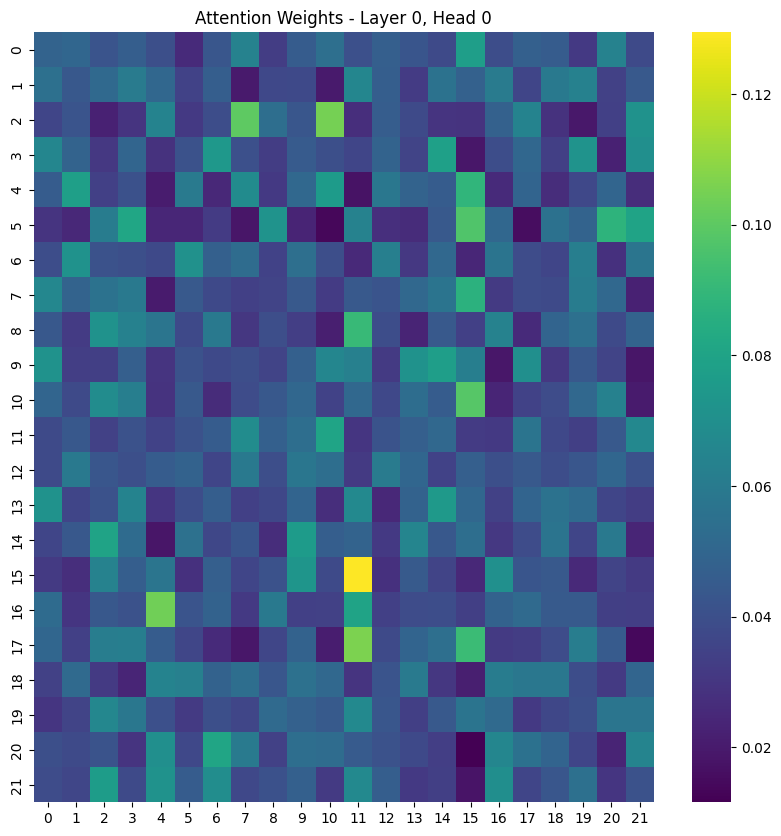

In [5]:
plot_attention_heatmap(attn_weights_storage[-1], batch_idx=0, layer=0, head=0)

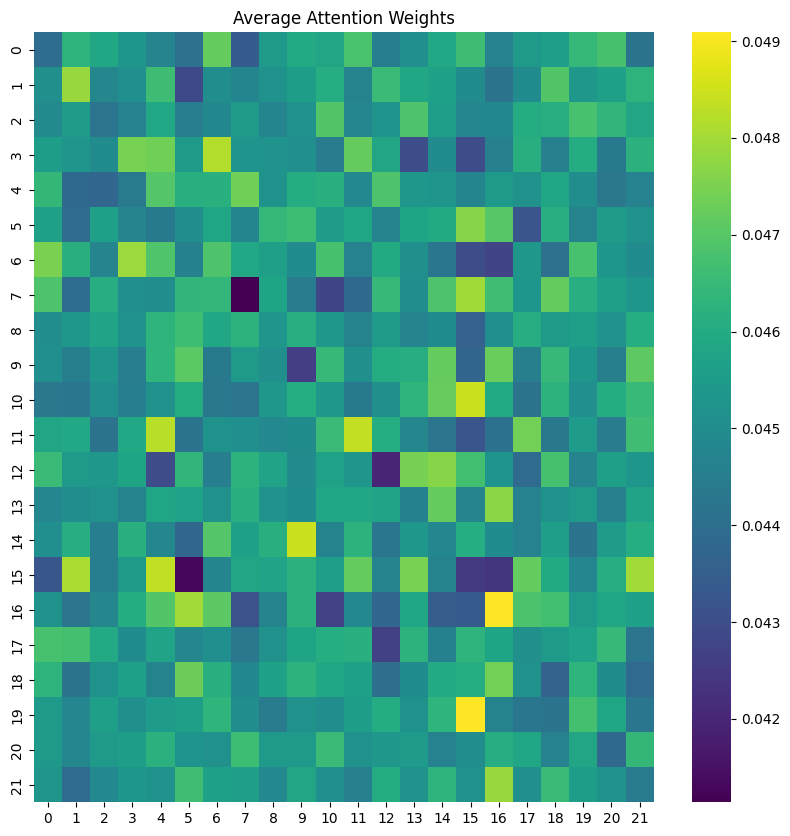

In [6]:
# Assuming attn_weights_storage is a list of tensors with shape [num_layers, batch_size, num_heads, seq_len, seq_len]

# Initialize average matrix
average_attention = torch.zeros(22, 22)

# Sum all attention weights
for attn_weights in attn_weights_storage:
    num_layers, current_batch_size, num_heads = attn_weights.shape[0], attn_weights.shape[1], attn_weights.shape[2]
    for layer in range(num_layers):
        for b in range(current_batch_size): # using current_batch_size to be flexible
            for head in range(num_heads):
                average_attention += attn_weights[layer, b, head]

# Divide by total number to get the average
total_items = sum([aw.shape[1] for aw in attn_weights_storage]) * num_layers * num_heads  # summing batch sizes from each stored tensor
average_attention /= total_items

# Convert to numpy and plot
average_attention_np = average_attention.detach().numpy()
plt.figure(figsize=(10,10))
sns.heatmap(average_attention_np, cmap='viridis')
plt.title("Average Attention Weights")
plt.savefig(f"att_weight_{dataset_name}.png")
plt.show()


### Census Income

In [ ]:
train = pd.read_csv('../tab-transformer-pytorch/census-income.csv')
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        # print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

train.loc[train[target] == 0, target] = "wealthy"
train.loc[train[target] == 1, target] = "not_wealthy"

unused_feat = ['Set']

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [ ]:
# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=2,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)


In [ ]:
# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Training loop (modified to store attention weights)
attn_weights_storage = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds, attn_weights = model(x_categ, x_cont, return_attn=True)
        attn_weights_storage.append(attn_weights) # Store attention weights
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation (assuming you don't need attention weights here)
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR Census-Income : {test_acc}")


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR Census-Income : 0.8607320099255583


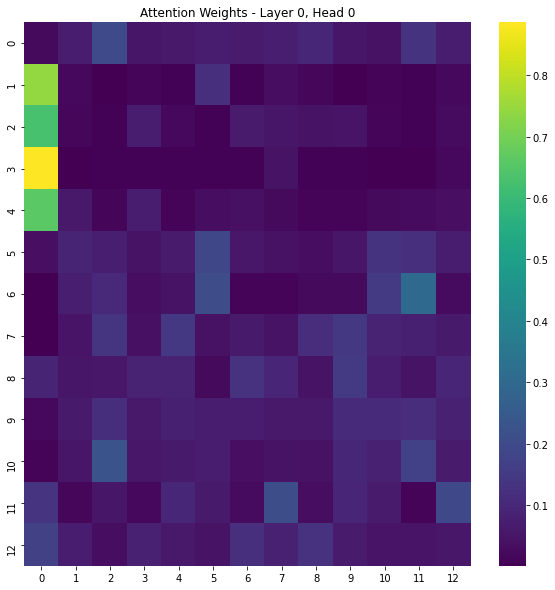

In [ ]:
plot_attention_heatmap(attn_weights_storage[-1], batch_idx=0, layer=0, head=0)

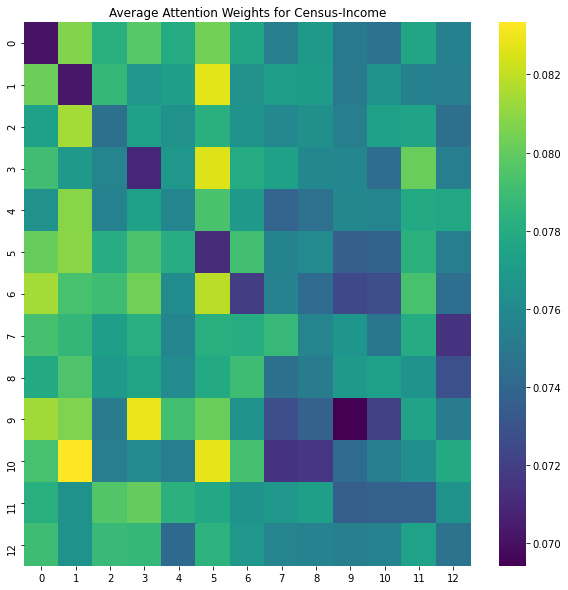

In [ ]:
# Assuming attn_weights_storage is a list of tensors with shape [num_layers, batch_size, num_heads, seq_len, seq_len]

# Initialize average matrix
average_attention = torch.zeros(len(features) - 1, len(features) - 1)

# Sum all attention weights
for attn_weights in attn_weights_storage:
    num_layers, current_batch_size, num_heads = attn_weights.shape[0], attn_weights.shape[1], attn_weights.shape[2]
    for layer in range(num_layers):
        for b in range(current_batch_size): # using current_batch_size to be flexible
            for head in range(num_heads):
                average_attention += attn_weights[layer, b, head]

# Divide by total number to get the average
total_items = sum([aw.shape[1] for aw in attn_weights_storage]) * num_layers * num_heads  # summing batch sizes from each stored tensor
average_attention /= total_items

# Convert to numpy and plot
average_attention_np = average_attention.detach().numpy()
plt.figure(figsize=(10,10))
sns.heatmap(average_attention_np, cmap='viridis')
plt.title("Average Attention Weights for Census-Income")
plt.savefig("att_weight_census.png")
plt.show()


### Blastchar

In [ ]:
dataset_name = 'blastchar'
train = pd.read_csv('../tab-transformer-pytorch/blastchar.csv')
target = 'Churn'
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=2,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Training loop (modified to store attention weights)
attn_weights_storage = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds, attn_weights = model(x_categ, x_cont, return_attn=True)
        attn_weights_storage.append(attn_weights) # Store attention weights
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation (assuming you don't need attention weights here)
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name}: {test_acc}")

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
FINAL TEST SCORE FOR blastchar: 0.7466288147622427


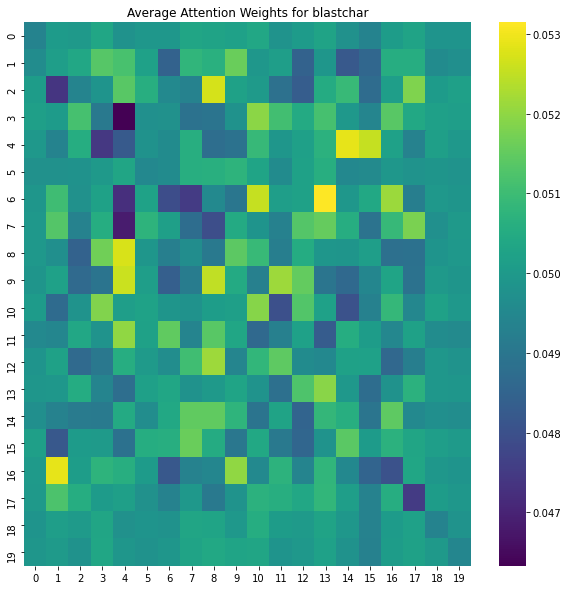

In [ ]:
# Assuming attn_weights_storage is a list of tensors with shape [num_layers, batch_size, num_heads, seq_len, seq_len]

# Initialize average matrix
average_attention = torch.zeros(len(features), len(features))

# Sum all attention weights
for attn_weights in attn_weights_storage:
    num_layers, current_batch_size, num_heads = attn_weights.shape[0], attn_weights.shape[1], attn_weights.shape[2]
    for layer in range(num_layers):
        for b in range(current_batch_size): # using current_batch_size to be flexible
            for head in range(num_heads):
                average_attention += attn_weights[layer, b, head]

# Divide by total number to get the average
total_items = sum([aw.shape[1] for aw in attn_weights_storage]) * num_layers * num_heads  # summing batch sizes from each stored tensor
average_attention /= total_items

# Convert to numpy and plot
average_attention_np = average_attention.detach().numpy()
plt.figure(figsize=(10,10))
sns.heatmap(average_attention_np, cmap='viridis')
plt.title(f"Average Attention Weights for {dataset_name}")
plt.savefig(f"att_weight_{dataset_name}.png")
plt.show()


### Diabetes

In [7]:
dataset_name = 'diabetes'
train = pd.read_csv('../tab-transformer-pytorch/diabetes.csv')
target = 'readmitted'
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=3,                # multiclass classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Training loop (modified to store attention weights)
attn_weights_storage = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds, attn_weights = model(x_categ, x_cont, return_attn=True)
        attn_weights_storage.append(attn_weights) # Store attention weights
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation (assuming you don't need attention weights here)
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name}: {test_acc}")

Epoch 1/10
Epoch 2/10


In [ ]:
# Assuming attn_weights_storage is a list of tensors with shape [num_layers, batch_size, num_heads, seq_len, seq_len]

# Initialize average matrix
average_attention = torch.zeros(len(features), len(features))

# Sum all attention weights
for attn_weights in attn_weights_storage:
    num_layers, current_batch_size, num_heads = attn_weights.shape[0], attn_weights.shape[1], attn_weights.shape[2]
    for layer in range(num_layers):
        for b in range(current_batch_size): # using current_batch_size to be flexible
            for head in range(num_heads):
                average_attention += attn_weights[layer, b, head]

# Divide by total number to get the average
total_items = sum([aw.shape[1] for aw in attn_weights_storage]) * num_layers * num_heads  # summing batch sizes from each stored tensor
average_attention /= total_items

# Convert to numpy and plot
average_attention_np = average_attention.detach().numpy()
plt.figure(figsize=(10,10))
sns.heatmap(average_attention_np, cmap='viridis')
plt.title(f"Average Attention Weights for {dataset_name}")
plt.savefig(f"att_weight_{dataset_name}.png")
plt.show()

### Forest

In [ ]:
dataset_name = '../tab-transformer-pytorch/forest-cover-type.csv'
target = 'Covertype'

bool_columns = [
        "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
        "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
        "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
        "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
        "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
        "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
        "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
        "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
        "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
        "Soil_Type40"
    ]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
        int_columns + bool_columns + [target])

train = pd.read_csv('../tab-transformer-pytorch/forest-cover-type.csv',
                    header=None, names=feature_columns)
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=7,                # multiclass classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Training loop (modified to store attention weights)
attn_weights_storage = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds, attn_weights = model(x_categ, x_cont, return_attn=True)
        attn_weights_storage.append(attn_weights) # Store attention weights
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation (assuming you don't need attention weights here)
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name}: {test_acc}")

In [ ]:
# Assuming attn_weights_storage is a list of tensors with shape [num_layers, batch_size, num_heads, seq_len, seq_len]

# Initialize average matrix
average_attention = torch.zeros(len(features), len(features))

# Sum all attention weights
for attn_weights in attn_weights_storage:
    num_layers, current_batch_size, num_heads = attn_weights.shape[0], attn_weights.shape[1], attn_weights.shape[2]
    for layer in range(num_layers):
        for b in range(current_batch_size): # using current_batch_size to be flexible
            for head in range(num_heads):
                average_attention += attn_weights[layer, b, head]

# Divide by total number to get the average
total_items = sum([aw.shape[1] for aw in attn_weights_storage]) * num_layers * num_heads  # summing batch sizes from each stored tensor
average_attention /= total_items

# Convert to numpy and plot
average_attention_np = average_attention.detach().numpy()
plt.figure(figsize=(10,10))
sns.heatmap(average_attention_np, cmap='viridis')
plt.title(f"Average Attention Weights for {dataset_name}")
plt.savefig(f"att_weight_{dataset_name}.png")
plt.show()

### Skip Higgs

### Poker Hand

In [ ]:
dataset_name = 'poker_hand'
target = 'poker_hand_class'

int_columns = [
    "suit1", "rank1", "suit2",
    "rank2", "suit3", "rank3", "suit4", "rank4",
    "suit5", "rank5"
]

feature_columns = (
        int_columns + [target])

dataset_train_1 = '../tab-transformer-pytorch/poker-hand-training-true.csv'
train_1 = pd.read_csv(dataset_train_1,
                    header=None, names=feature_columns)

dataset_train_2 = '../tab-transformer-pytorch/poker-hand-testing.csv'
train_2 = pd.read_csv(dataset_train_2,
                    header=None, names=feature_columns)

train = pd.concat([train_1, train_2], axis=0)
n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    # print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

unused_feat = []

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TabTransformer model
model = TabTransformer(
    categories=cat_dims,      # dimensions of categorical columns
    num_continuous=len(features) - len(cat_dims), # number of continuous values
    dim=32,
    dim_out=10,                # binary classification
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(4, 2)
)

# 3. Train the Model
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# Training loop (modified to store attention weights)
attn_weights_storage = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    for x_categ, x_cont, y in train_loader:
        preds, attn_weights = model(x_categ, x_cont, return_attn=True)
        attn_weights_storage.append(attn_weights) # Store attention weights
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation (assuming you don't need attention weights here)
model.eval()
all_preds = []
with torch.no_grad():
    for x_categ, x_cont, _ in test_loader:
        preds = model(x_categ, x_cont)
        all_preds.extend(preds.argmax(dim=1).tolist())

y_pred = np.array(all_preds)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name}: {test_acc}")

FileNotFoundError: [Errno 2] File poker-hand-training-true.csv does not exist: 'poker-hand-training-true.csv'

In [ ]:
# Assuming attn_weights_storage is a list of tensors with shape [num_layers, batch_size, num_heads, seq_len, seq_len]

# Initialize average matrix
average_attention = torch.zeros(len(features), len(features))

# Sum all attention weights
for attn_weights in attn_weights_storage:
    num_layers, current_batch_size, num_heads = attn_weights.shape[0], attn_weights.shape[1], attn_weights.shape[2]
    for layer in range(num_layers):
        for b in range(current_batch_size): # using current_batch_size to be flexible
            for head in range(num_heads):
                average_attention += attn_weights[layer, b, head]

# Divide by total number to get the average
total_items = sum([aw.shape[1] for aw in attn_weights_storage]) * num_layers * num_heads  # summing batch sizes from each stored tensor
average_attention /= total_items

# Convert to numpy and plot
average_attention_np = average_attention.detach().numpy()
plt.figure(figsize=(10,10))
sns.heatmap(average_attention_np, cmap='viridis')
plt.title(f"Average Attention Weights for {dataset_name}")
plt.savefig(f"att_weight_{dataset_name}.png")
plt.show()